In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [3]:
import random
import numpy as np
import torch

# Setting the seed for Python's built-in random module
random.seed(42)

# Setting the seed for numpy's random number generator
np.random.seed(42)

# Setting the seed for PyTorch (both CPU and GPU)
torch.manual_seed(2147483647)

# If using CUDA, set the seed for all GPUs
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2147483647)

# Ensuring deterministic behavior in PyTorch
torch.use_deterministic_algorithms(True)

# Optionally, set the environment variable for deterministic behavior in cuDNN
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Select the device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Device: cpu


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Download and prepare the MNIST dataset
mnist_train_val = torchvision.datasets.MNIST(
    root='datasets/mnist', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='datasets/mnist', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = 50000
val_size = len(mnist_train_val) - train_size
train_subset, val_subset = torch.utils.data.random_split(mnist_train_val, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

# Print the sizes of the datasets to verify
print(f'Training set size: {len(train_subset)}')
print(f'Validation set size: {len(val_subset)}')
print(f'Test set size: {len(mnist_test)}')


Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 9912422/9912422 [00:00<00:00, 130192212.23it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 49182173.70it/s]

Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 86355809.96it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4751940.33it/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



Training set size: 50000
Validation set size: 10000
Test set size: 10000


In [5]:
import torch
import torchvision

# Function to print dimensions of images and labels in the data loader
def check_loader_dimensions(loaders):
    for name, loader in loaders.items():
        num_samples = len(loader.dataset)
        data_iter = iter(loader)
        images, labels = next(data_iter)
        print(f'Loader: {name}')
        print(f'Number of samples: {num_samples}')
        print(f'Image batch shape: {images.shape}')
        print(f'Label batch shape: {labels.shape}')
        print('------------------------')

# Define preprocessing transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare the MNIST dataset
mnist_train_val = torchvision.datasets.MNIST(
    root='datasets/mnist', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='datasets/mnist', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = 50000
val_size = len(mnist_train_val) - train_size
train_subset, val_subset = torch.utils.data.random_split(mnist_train_val, [train_size, val_size])

# Create data loaders
loaders = {
    'train_loader': torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True),
    'val_loader': torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False),
    'test_loader': torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)
}

# Check and print dimensions
check_loader_dimensions(loaders)


Loader: train_loader
Number of samples: 50000
Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])
------------------------
Loader: val_loader
Number of samples: 10000
Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])
------------------------
Loader: test_loader
Number of samples: 10000
Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])
------------------------


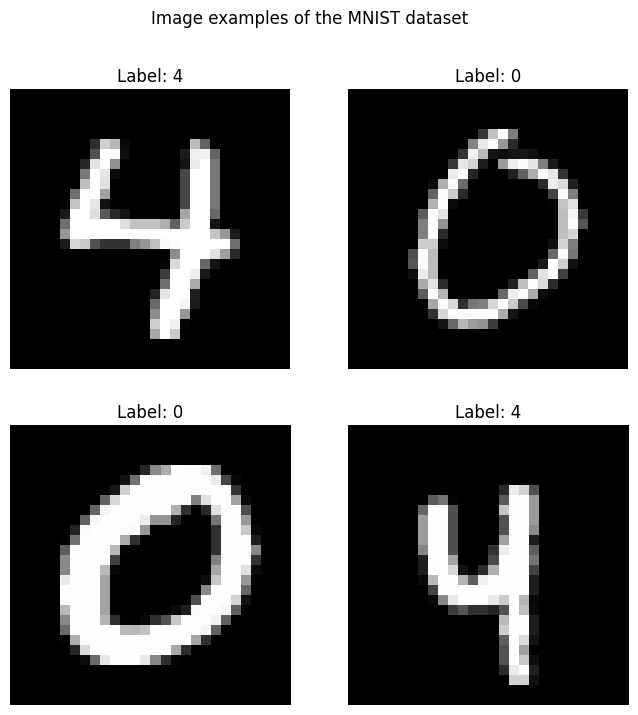

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define preprocessing transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare the MNIST dataset
mnist_train_val = torchvision.datasets.MNIST(
    root='datasets/mnist', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='datasets/mnist', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = 50000
val_size = len(mnist_train_val) - train_size
train_subset, val_subset = torch.utils.data.random_split(mnist_train_val, [train_size, val_size])

# Visualize examples
def visualize_examples(dataset, num_images=4):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze().numpy()

        plt.subplot(2, 2, i + 1)
        plt.title(f'Label: {label}')
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.suptitle("Image examples of the MNIST dataset")
    plt.show()

# Visualize examples from the validation set
visualize_examples(val_subset)


In [7]:
# Define model hyperparameters and configurations using a dictionary
model_config = {
    'image_size': 28,
    'embed_dim': 256,
    'hidden_dim': 256 * 3,
    'num_heads': 8,
    'num_layers': 6,
    'patch_size': 7,
    'num_patches': 16,
    'num_channels': 1,
    'num_classes': 10,
    'dropout': 0.2
}

# Accessing the parameters from the dictionary
image_size = model_config['image_size']
embed_dim = model_config['embed_dim']
hidden_dim = model_config['hidden_dim']
num_heads = model_config['num_heads']
num_layers = model_config['num_layers']
patch_size = model_config['patch_size']
num_patches = model_config['num_patches']
num_channels = model_config['num_channels']
num_classes = model_config['num_classes']
dropout = model_config['dropout']

# Print the configurations to verify
for key, value in model_config.items():
    print(f'{key}: {value}')


image_size: 28
embed_dim: 256
hidden_dim: 768
num_heads: 8
num_layers: 6
patch_size: 7
num_patches: 16
num_channels: 1
num_classes: 10
dropout: 0.2


In [8]:
def image_to_patches(images, patch_size, flatten_channels=True):

    # Get the shape of the input images
    batch_size, num_channels, height, width = images.shape  # MNIST: [B, 1, 28, 28]

    # Calculate the number of patches along height and width
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size

    # Reshape to separate patches
    reshaped_images = images.reshape(batch_size, num_channels, num_patches_height, patch_size, num_patches_width, patch_size)  # [B, C, H//p, p, W//p, p]

    # Permute dimensions to bring patches to the front
    permuted_images = reshaped_images.permute(0, 2, 4, 1, 3, 5)  # [B, H//p, W//p, C, p, p]

    # Flatten the height and width dimensions to get patches
    patches = permuted_images.flatten(1, 2)  # [B, (H//p)*(W//p), C, p, p]

    if flatten_channels:
        # Flatten the channel and patch dimensions to get a vector representation of patches
        patches = patches.flatten(2, 4)  # [B, (H//p)*(W//p), C*p*p]

    return patches


x = torch.randn(32, 1, 28, 28)
patches = image_to_patches(x, patch_size=7, flatten_channels=True)
print(patches.shape)


torch.Size([32, 16, 49])


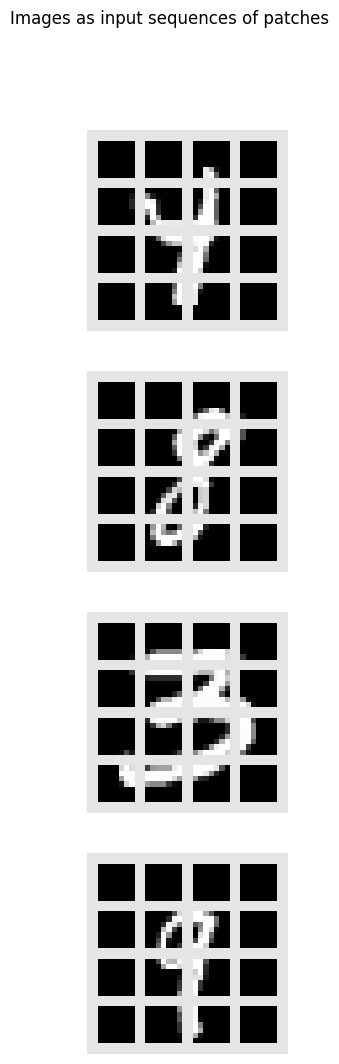

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define preprocessing transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare the MNIST dataset
mnist_train_val = torchvision.datasets.MNIST(
    root='datasets/mnist', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='datasets/mnist', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = 50000
val_size = len(mnist_train_val) - train_size
train_subset, val_subset = torch.utils.data.random_split(mnist_train_val, [train_size, val_size])

# Function to convert images to patches
def image_to_patches(images, patch_size, flatten_channels=True):

    batch_size, num_channels, height, width = images.shape  # MNIST: [B, 1, 28, 28]

    # Calculate the number of patches along height and width
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size

    # Reshape to separate patches
    reshaped_images = images.reshape(batch_size, num_channels, num_patches_height, patch_size, num_patches_width, patch_size)  # [B, C, H//p, p, W//p, p]

    # Permute dimensions to bring patches to the front
    permuted_images = reshaped_images.permute(0, 2, 4, 1, 3, 5)  # [B, H//p, W//p, C, p, p]

    # Flatten the height and width dimensions to get patches
    patches = permuted_images.flatten(1, 2)  # [B, (H//p)*(W//p), C, p, p]

    if flatten_channels:
        # Flatten the channel and patch dimensions to get a vector representation of patches
        patches = patches.flatten(2, 4)  # [B, (H//p)*(W//p), C*p*p]

    return patches

# Function to visualize image patches
def visualize_image_patches(images, patch_size, num_examples=4):

    # Get the image patches
    img_patches = image_to_patches(images[:num_examples], patch_size, flatten_channels=False)

    # Create the subplot
    fig, axes = plt.subplots(num_examples, 1, figsize=(14, 12))
    fig.suptitle("Images as input sequences of patches")

    for i in range(num_examples):
        # Create a grid of patches
        img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(images.shape[2] / patch_size), normalize=True, pad_value=0.9)
        img_grid = img_grid.permute(1, 2, 0)  # Change shape for plotting

        # Plot the grid of patches
        axes[i].imshow(img_grid)
        axes[i].axis("off")

    plt.show()
    plt.close()

# Visualize some examples from the validation set
visualize_image_patches(torch.stack([val_subset[idx][0] for idx in range(4)], dim=0), patch_size=7)


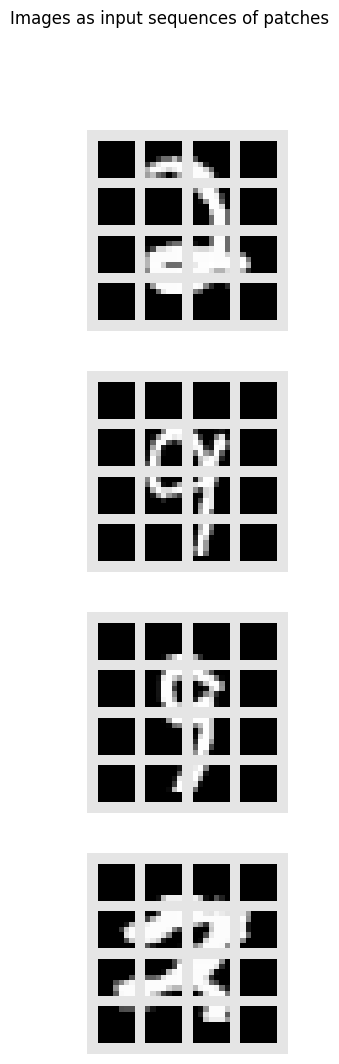

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define preprocessing transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare the MNIST dataset
mnist_train_val = torchvision.datasets.MNIST(
    root='datasets/mnist', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='datasets/mnist', train=False, transform=transform, download=True)

# Split the training dataset into training and validation sets
train_size = 50000
val_size = len(mnist_train_val) - train_size
train_subset, val_subset = torch.utils.data.random_split(mnist_train_val, [train_size, val_size])

class ImagePatcher:
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def to_patches(self, images, flatten_channels=True):

        batch_size, num_channels, height, width = images.shape  # MNIST: [B, 1, 28, 28]

        # Calculate the number of patches along height and width
        num_patches_height = height // self.patch_size
        num_patches_width = width // self.patch_size

        # Reshape to separate patches
        reshaped_images = images.reshape(batch_size, num_channels, num_patches_height, self.patch_size, num_patches_width, self.patch_size)  # [B, C, H//p, p, W//p, p]

        # Permute dimensions to bring patches to the front
        permuted_images = reshaped_images.permute(0, 2, 4, 1, 3, 5)  # [B, H//p, W//p, C, p, p]

        # Flatten the height and width dimensions to get patches
        patches = permuted_images.flatten(1, 2)  # [B, (H//p)*(W//p), C, p, p]

        if flatten_channels:
            # Flatten the channel and patch dimensions to get a vector representation of patches
            patches = patches.flatten(2, 4)  # [B, (H//p)*(W//p), C*p*p]

        return patches


class PatchVisualizer:
    def __init__(self, patch_size):
        self.patcher = ImagePatcher(patch_size)

    def visualize(self, images, num_examples=4):

        # Get the image patches
        img_patches = self.patcher.to_patches(images[:num_examples], flatten_channels=False)

        # Create the subplot
        fig, axes = plt.subplots(num_examples, 1, figsize=(14, 12))
        fig.suptitle("Images as input sequences of patches")

        for i in range(num_examples):
            # Create a grid of patches
            img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(images.shape[2] / self.patcher.patch_size), normalize=True, pad_value=0.9)
            img_grid = img_grid.permute(1, 2, 0)  # Change shape for plotting

            # Plot the grid of patches
            axes[i].imshow(img_grid)
            axes[i].axis("off")

        plt.show()
        plt.close()

# Instantiate the visualizer and visualize some examples from the validation set
visualizer = PatchVisualizer(patch_size=7)
visualizer.visualize(torch.stack([val_subset[idx][0] for idx in range(4)], dim=0))


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim=None, dropout=0.0):
        super().__init__()

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Linear transformations for queries, keys, and values
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        # Feed-forward network
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim if hidden_dim else embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim if hidden_dim else embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, N, C = x.size()  # Batch size, sequence length, embed dim

        # Linear transformations
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        # Split into multiple heads
        queries = queries.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # B x num_heads x N x head_dim
        keys = keys.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # B x num_heads x N x head_dim
        values = values.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # B x num_heads x N x head_dim

        # Scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale  # B x num_heads x N x N
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, values)  # B x num_heads x N x head_dim

        # Combine heads and reshape
        attention_output = attention_output.transpose(1, 2).contiguous().view(B, N, C)  # B x N x C

        # Add and norm
        x = x + attention_output
        x = self.layer_norm(x)

        # Feed-forward network
        x = x + self.linear(x)
        return x


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, embed_dim):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, C, H, W) -> (B, embed_dim, H_out, W_out)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, embed_dim, H_out * W_out)
        return x

class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.size()
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        queries = queries.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(self.dropout(attention_weights), values)
        attention_output = attention_output.transpose(1, 2).contiguous().view(B, N, C)

        return self.out(attention_output)

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        num_channels,
        embed_dim,
        num_heads,
        num_layers,
        num_classes,
        dropout=0.0
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(image_size, patch_size, num_channels, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.patch_embed.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.transformer = nn.ModuleList([
            Attention(embed_dim, num_heads, dropout=dropout) for _ in range(num_layers)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            MLP(embed_dim, embed_dim * 4, dropout=dropout),
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding

        for layer in self.transformer:
            x = layer(x)

        x = x.mean(dim=1)
        x = self.mlp_head(x)

        return x


In [13]:
import torch
import torch.nn as nn
import os

class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_heads,
        num_layers,
        patch_size,
        num_channels,
        num_patches,
        num_classes,
        dropout=0.0
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(patch_size, num_channels, embed_dim, image_size=224)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding

        for block in self.transformer:
            x = block(x)

        x = x.mean(dim=1)
        x = self.mlp_head(x)

        return x

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, num_channels, embed_dim, image_size=224):
        super().__init__()
        self.proj = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.image_size = image_size
        self.num_patches = (image_size // patch_size) ** 2

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.0):
        super().__init__()
        self.attention = Attention(embed_dim, num_heads, dropout)
        self.mlp = MLP(embed_dim, hidden_dim, dropout)

    def forward(self, x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x

class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.size()
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        queries = queries.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(self.dropout(attention_weights), values)
        attention_output = attention_output.transpose(1, 2).contiguous().view(B, N, C)

        return self.out(attention_output)

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Usage
embed_dim = 256
hidden_dim = 512
num_heads = 8
num_layers = 6
patch_size = 16
num_channels = 3
num_patches = (224 // patch_size) ** 2
num_classes = 10
dropout = 0.1

# Instantiate the model
model = VisionTransformer(
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    patch_size=patch_size,
    num_channels=num_channels,
    num_patches=num_patches,
    num_classes=num_classes,
    dropout=dropout
)

# Transfer to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Model restoration logic
model_restore = '/path/to/your/model.pth'
if model_restore and os.path.isfile(model_restore):
    model.load_state_dict(torch.load(model_restore, map_location=device))
    model.restored = True
    print("Model restored from", model_restore)
else:
    print("No checkpoint found at", model_restore)

# Example usage
input_data = torch.randn(1, 3, 224, 224).to(device)
output = model(input_data)
print(output)


No checkpoint found at /path/to/your/model.pth
tensor([[ 0.6042, -0.3989, -0.6561, -0.0827,  0.8026, -0.0070, -1.0003,  0.4979,
          0.9631, -0.0143]], grad_fn=<AddmmBackward0>)


In [14]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): Attention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out): Linear(in_features=256, out_features=256, bias=True)
      )
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=Fa

In [15]:
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
from tqdm import tqdm

# Assuming VisionTransformer and other components are already defined
# Define VisionTransformer and other necessary components (already provided earlier)

# Function to evaluate model accuracy on test set
def evaluate_model_accuracy(model, test_loader, device):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc='Evaluating'):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, pred_cls = preds.max(1)
            correct_predictions += pred_cls.eq(labels).sum().item()

    accuracy = correct_predictions / len(test_loader.dataset)
    return accuracy

# Example usage
if __name__ == "__main__":
    # Define hyperparameters and other settings
    embed_dim = 256
    hidden_dim = 512
    num_heads = 8
    num_layers = 6
    patch_size = 7  # Adjusted for MNIST (28x28 images with 4x4 patches)
    num_channels = 1  # MNIST is grayscale
    num_patches = (28 // patch_size) ** 2
    num_classes = 10  # MNIST has 10 classes
    dropout = 0.1
    batch_size = 64

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VisionTransformer(
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        patch_size=patch_size,
        num_channels=num_channels,
        num_patches=num_patches,
        num_classes=num_classes,
        dropout=dropout
    ).to(device)

    # Load pre-trained weights if available
    # model.load_state_dict(torch.load('path_to_your_saved_model.pth'))

    # Load test dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate model accuracy on test set
    test_accuracy = evaluate_model_accuracy(model, test_loader, device)
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 120796067.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 54126762.21it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 32079799.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8581319.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Evaluating: 100%|██████████| 157/157 [00:33<00:00,  4.75it/s]

Accuracy on test set: 9.74%


In [16]:
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
from tqdm import tqdm

# Load the MNIST test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Find the index of the 5th occurrence of label 8 in the test dataset
label_to_find = 8
count = 0
target_index = None

for i in range(len(test_dataset.targets)):
    if test_dataset.targets[i] == label_to_find:
        count += 1
        if count == 5:  # Adjust this number to find the Nth occurrence
            target_index = i
            break

if target_index is not None:
    # Perform any operation using the found index
    print(f"Index of the 5th sample with label {label_to_find}: {target_index}")
    # Example: Access the image and label
    image, label = test_dataset[target_index]
    print(f"Label: {label}")
    # Perform further operations with the image or label
else:
    print(f"No sample found with label {label_to_find}")

# Example usage of evaluating model accuracy on test set
def evaluate_model_accuracy(model, test_loader, device):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc='Evaluating'):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, pred_cls = preds.max(1)
            correct_predictions += pred_cls.eq(labels).sum().item()

    accuracy = correct_predictions / len(test_loader.dataset)
    return accuracy

# Example usage
if __name__ == "__main__":
    # Assuming VisionTransformer and other components are defined earlier
    # Initialize hyperparameters, model, device, etc.

    # Load pre-trained weights if available
    # model.load_state_dict(torch.load('path_to_your_saved_model.pth'))

    # Load test dataset (already loaded as test_dataset above)

    # Example of evaluating model accuracy on the entire test set
    batch_size = 64
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate model accuracy on test set
    test_accuracy = evaluate_model_accuracy(model, test_loader, device)
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')


Index of the 5th sample with label 8: 134
Label: 8


Evaluating: 100%|██████████| 157/157 [00:25<00:00,  6.09it/s]

Accuracy on test set: 9.74%


In [19]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define VisionTransformer class
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, num_layers, patch_size, num_channels, num_patches, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.input_layer = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.transformer = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.input_layer(x)  # Shape: [batch_size, embed_dim, num_patches**0.5, num_patches**0.5]
        patches = patches.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, embed_dim]
        batch_size = patches.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, embed_dim]
        x = torch.cat((cls_tokens, patches), dim=1)  # Shape: [batch_size, num_patches + 1, embed_dim]
        x += self.pos_embedding[:, :(x.size(1)), :]  # Add position embedding

        for layer in self.transformer:
            x = layer(x)

        x = self.fc(x[:, 0])  # Take the cls_token output
        return x

# Example usage
if __name__ == "__main__":
    # Define hyperparameters and other settings
    embed_dim = 256
    hidden_dim = 256
    num_heads = 8
    num_layers = 6
    patch_size = 7  # Adjust based on your model's patch size
    num_channels = 1  # MNIST is grayscale
    num_patches = (28 // patch_size) ** 2  # Assuming MNIST 28x28 images
    num_classes = 10  # MNIST has 10 classes

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VisionTransformer(
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        patch_size=patch_size,
        num_channels=num_channels,
        num_patches=num_patches,
        num_classes=num_classes
    ).to(device)

    # Load test dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Select a specific test sample index where the label is 8
    test_sample_index = (test_dataset.targets == 8).nonzero(as_tuple=True)[0][5].item()
    img_tensor = test_dataset.data[test_sample_index].unsqueeze(0).unsqueeze(0).float()  # Shape: [1, 1, 28, 28]

    # Move input tensor to device
    img_tensor = img_tensor.to(device)

    # Convert the test sample into patches using the input layer
    patches = model.input_layer(img_tensor)  # Shape: [1, embed_dim, H, W]
    patches = patches.view(1, embed_dim, -1).permute(0, 2, 1)  # Shape: [1, num_patches, embed_dim]

    # Attach the class token and add the position embedding
    cls_token = model.cls_token.expand(1, -1, -1)  # Shape: [1, 1, embed_dim]
    pos_embedding = model.pos_embedding[:, :patches.size(1) + 1, :]  # Shape: [1, num_patches + 1, embed_dim]

    # Concatenate class token and patches
    transformer_input = torch.cat((cls_token, patches), dim=1) + pos_embedding

    print("Input tensor to Transformer: ", transformer_input.shape)

    # Forward pass through the transformer layers
    for layer in model.transformer:
        transformer_input = layer(transformer_input)

    print("Output shape after transformer layers: ", transformer_input.shape)


Input tensor to Transformer:  torch.Size([1, 17, 256])
Output shape after transformer layers:  torch.Size([1, 17, 256])


In [24]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

# Define VisionTransformer class
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, num_layers, patch_size, num_channels, num_patches, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.input_layer = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.transformer = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.input_layer(x)  # Shape: [batch_size, embed_dim, num_patches**0.5, num_patches**0.5]
        patches = patches.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, embed_dim]
        batch_size = patches.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, embed_dim]
        x = torch.cat((cls_tokens, patches), dim=1)  # Shape: [batch_size, num_patches + 1, embed_dim]
        x += self.pos_embedding[:, :(x.size(1)), :]  # Add position embedding

        for layer in self.transformer:
            x = layer(x)

        x = self.fc(x[:, 0])  # Take the cls_token output
        return x

# Define hyperparameters and other settings
embed_dim = 2304  # Adjusted to be divisible by 24 (3 * num_heads)
hidden_dim = 2304
num_heads = 8
num_layers = 6
patch_size = 7  # Adjust based on your model's patch size
num_channels = 1  # MNIST is grayscale
num_patches = (28 // patch_size) ** 2  # Assuming MNIST 28x28 images
num_classes = 10  # MNIST has 10 classes

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    patch_size=patch_size,
    num_channels=num_channels,
    num_patches=num_patches,
    num_classes=num_classes
).to(device)

# Load test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select a specific test sample index where the label is 8
test_sample_index = (test_dataset.targets == 8).nonzero(as_tuple=True)[0][5].item()
img_tensor = test_dataset.data[test_sample_index].unsqueeze(0).unsqueeze(0).float()  # Shape: [1, 1, 28, 28]

# Move input tensor to device
img_tensor = img_tensor.to(device)

# Convert the test sample into patches using the input layer
patches = model.input_layer(img_tensor)  # Shape: [1, embed_dim, H, W]
patches = patches.view(1, embed_dim, -1).permute(0, 2, 1)  # Shape: [1, num_patches, embed_dim]

# Attach the class token and add the position embedding
cls_token = model.cls_token.expand(1, -1, -1)  # Shape: [1, 1, embed_dim]
pos_embedding = model.pos_embedding[:, :patches.size(1) + 1, :]  # Shape: [1, num_patches + 1, embed_dim]
transformer_input = torch.cat((cls_token, patches), dim=1) + pos_embedding

print("Input tensor to Transformer: ", transformer_input.shape)

# Forward pass through the transformer layers
for layer in model.transformer:
    transformer_input = layer(transformer_input)

print("Output shape after transformer layers: ", transformer_input.shape)

# Expand the input using the first transformer layer's linear transformation
transformer_input_expanded = model.transformer[0].linear1(transformer_input)  # Assuming linear1 exists

print("transformer_input_expanded shape: ", transformer_input_expanded.shape)

# Compute the last dimension
last_dim = transformer_input_expanded.shape[2] // num_heads

# Ensure last_dim is divisible by num_heads
assert transformer_input_expanded.shape[2] % num_heads == 0, f"Dimension mismatch: {transformer_input_expanded.shape[2]} is not divisible by {num_heads}"

# Split qkv into multiple q, k, and v vectors for multi-head attention
qkv = transformer_input_expanded.view(transformer_input_expanded.size(0), transformer_input_expanded.size(1), num_heads, last_dim)
qkv = qkv.permute(2, 0, 3, 1)  # Shape: [num_heads, batch_size, last_dim, num_patches+1]

# Extract q, k, and v
q, k, v = qkv[0], qkv[1], qkv[2]  # Each has shape: [batch_size, last_dim, num_patches+1]

attention_matrix = torch.matmul(q.transpose(1, 2), k)

print("Attention matrix shape: ", attention_matrix.shape)



Input tensor to Transformer:  torch.Size([1, 17, 2304])
Output shape after transformer layers:  torch.Size([1, 17, 2304])
transformer_input_expanded shape:  torch.Size([1, 17, 2048])
Attention matrix shape:  torch.Size([1, 17, 17])


In [25]:
import torch
attention_matrix_mean = torch.mean(attention_matrix, dim=0)
residual_att = torch.eye(attention_matrix_mean.size(0)).to(device)
aug_att_mat = attention_matrix_mean + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)

joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

print("Final joint attentions shape:", joint_attentions.shape)


Final joint attentions shape: torch.Size([17, 17])


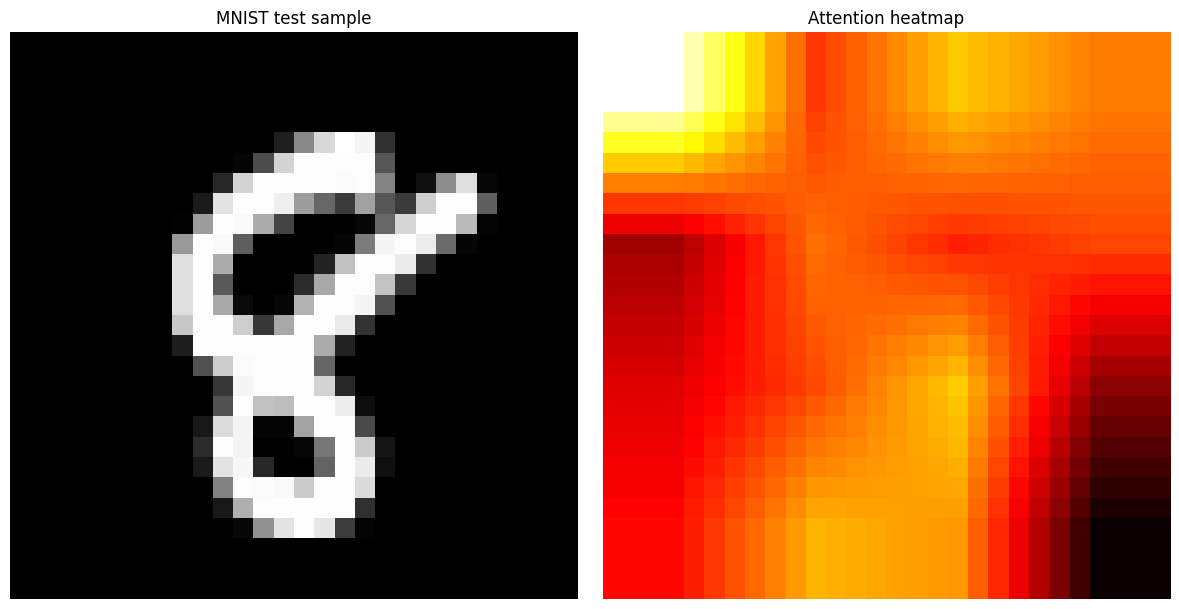

In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


attn_heatmap = joint_attentions[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), size=(image_size, image_size), mode='bilinear').view(image_size, image_size, 1)
attn_heatmap_resized_np = attn_heatmap_resized.detach().cpu().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu().squeeze())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.axis('off')
ax2.imshow(attn_heatmap_resized_np.squeeze(), cmap='hot', interpolation='nearest')
ax2.set_title('Attention heatmap')
ax2.axis('off')

plt.tight_layout()
plt.show()
